# 3D Visualization of cooling SC/KA Lennard-Jones with rumdpy 

In [4]:
# Reproducing 'ATU' run in phd1:
#    LJ, N=864, rho=0.60, cooling from T=3.0 to 0.1 with dt=0.005, 
#    scalars: every 20'th step, trajectory: 194 log-blocks    
#
# Timestep:                                        200_000                2_000_000
# Rumd3  GTX TITAN,        4.5 TFlops, 288 GB/s, runtime: 56   sec        196   sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 11.8s, rumd_msd: 6s
# Rumd3  RTX 2080 Ti,     11.7 TFlops, 616 GB/s, runtime: 38.9 sec         77.8 sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 11.8s, rumd_msd: 6s
# rumdpy RTX 3070 Laptop, 11.4 TFlops, 448 GB/s, runtime: 10.0 sec (256k)  39.9 sec (1000 conf_blocks * 257/167z Kb)  on-the-fly     ~1s 

## Imports

In [5]:
import numpy as np
import rumdpy as rp
#import pandas as pd # Can be removed when all saving is moved to class Simulation
import numba        # Can be removed when handling od RDF arrays is moved to class Simulation (or its own class)

import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget


SystemError: initialization of _internal failed without raising an exception

## Generate configuration with a FCC lattice

In [3]:
include_KABLJ = True

c1 = rp.make_configuration_fcc(nx=6,  ny=6,  nz=6,  rho=0.60,  T=3.44) 
if include_KABLJ:
    c1.ptype[::5] = 1 # 4:1 mixture

print(f'Number of particles: {c1.N}; Density: {c1.N/np.prod(c1.simbox.lengths):.3f}; B fraction: {np.mean(c1.ptype==1):.3f}')


NameError: name 'rp' is not defined

## Setup Lennard-Jones pair potential

In [15]:
pairfunc = rp.apply_shifted_force_cutoff(rp.LJ_12_6_sigma_epsilon)
sig = [[1.00, 0.80],
       [0.80, 0.88]]
eps = [[1.00, 1.50],
       [1.50, 0.50]]
cut = np.array(sig)*2.5
pairpot = rp.PairPotential2(pairfunc, params=[sig, eps, cut], max_num_nbs=1000)
#pairpot.plot(names=['A', 'B'])

## Setup integrator

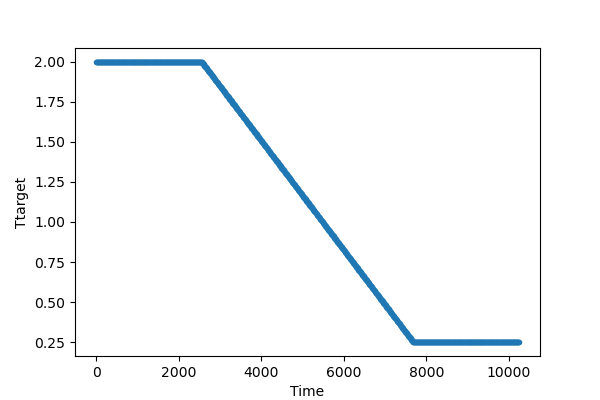

In [16]:
dt = 0.005 # timestep 
num_blocks = 1000         # Do simulation in this many 'blocks'
steps_per_block = 2*1024  # ... each of this many steps
running_time = dt*num_blocks*steps_per_block

Ttarget_function = rp.make_function_ramp(value0=2.00, x0=running_time*(1/4), 
                                         value1=0.25, x1=running_time*(3/4))
integrator = rp.integrators.NVT(Ttarget_function, tau=0.2, dt=dt)

plt.figure(figsize=(6,4))
t = np.linspace(0,running_time,num_blocks)
plt.plot(t, numba.vectorize(Ttarget_function)(t), '.-')
plt.xlabel('Time')
plt.ylabel('Ttarget')
plt.show()

## Run simulation

In [17]:
sim = rp.Simulation(c1, pairpot, integrator, 
                    num_blocks=num_blocks, steps_per_block=steps_per_block, 
                    storage='memory')

	pb: 8, tp:16, num_blocks:108
	Number (virtual) particles: 864
	Number of threads 13824
Generating NVT kernel for 864 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:108
	Number (virtual) particles: 864
	Number of threads 13824
Configurations per block (log2-storing): 13
Storing results in memory. Expected footprint  257.08 MB.


Start by running only part of the simulation. Might be for testing/benchmark/equilibration:

In [18]:
for block in sim.blocks(num_blocks=100):
    if block%25==0:
        print(block, end=' ')
print('\n', sim.summary())

0 25 50 75 
 particles : 864 
steps : 204800 
nbflag : [    0     0 22318] 
time : 5.35 s 
TPS : 3.82e+04


In [8]:
for block in sim.blocks(num_blocks=100):
    if block%25==0:
        print(block, end=' ')
print('\n', sim.summary())

0 25 50 75 
 particles : 864 
steps : 204800 
nbflag : [    0     0 44595] 
time : 3.69 s 
TPS : 5.55e+04


The difference (~1.5 second) is the time taken on first run to do just-in-time (JIT) compilation to the GPU.

In [19]:
sim = rp.Simulation(c1, pairpot, integrator, 
                    num_blocks=num_blocks, steps_per_block=steps_per_block, 
                    storage='Data/LJ_output.h5')

	pb: 8, tp:16, num_blocks:108
	Number (virtual) particles: 864
	Number of threads 13824
Generating NVT kernel for 864 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:108
	Number (virtual) particles: 864
	Number of threads 13824
Configurations per block (log2-storing): 13
Saving results in hdf5 format. Filename: Data/LJ_output.h5


In [20]:
for block in sim.blocks(num_blocks=100):
    if block%25==0:
        print(block, end=' ')
print('\n', sim.summary())

0 25 50 75 
 particles : 864 
steps : 204800 
nbflag : [    0     0 22349] 
time : 5.46 s 
TPS : 3.75e+04


## Run with 3D visualization

In [21]:
from rumdpy.visualization import k3d_Visualization # Requires the 'k3d' package

viz = k3d_Visualization(sim)
viz.display()
for block in sim.blocks(1000):
    viz.update(block, choice=0)
viz.display_player()
print('\n', sim.summary())

Output()


 particles : 864 
steps : 2048000 
nbflag : [     0      0 176643] 
time : 41.53 s 
TPS : 4.93e+04
